This notebook is intended to test the mavenn functionality which enables the computation of parameter uncertainties via inference on simulated data

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

# Load mavenn and check path
import mavenn

# Import helper functions
from helper_functions import my_rsquared, save_fig_with_date_stamp

# Set random seed
np.random.seed(0)

# Set figure name
fig_name = 'figS3'

In [2]:
style_file_name = f'{fig_name}.style'
s = """
axes.linewidth:     0.5     # edge linewidth
font.size:          8.0
axes.labelsize:     8.0  # fontsize of the x any y labels
axes.titlesize:     8.0
xtick.labelsize:    8.0  # fontsize of the tick labels
ytick.labelsize:    8.0  # fontsize of the tick labels
legend.fontsize:      8.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
legend.framealpha:    1.0 
lines.dash_capstyle:   round        # {butt, round, projecting}
lines.solid_capstyle:   round        # {butt, round, projecting}
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [3]:
# Load model
model = mavenn.load('../models/mpsa_pairwise_ge_2021.12.30.21h.07m')

Model loaded from these files:
	../models/mpsa_pairwise_ge_2021.12.30.21h.07m.pickle
	../models/mpsa_pairwise_ge_2021.12.30.21h.07m.h5


In [4]:
# Save models
sim_models = []
for model_num in range(20):
    sim_model = mavenn.load(f'../models/mpsa_pairwise_ge_model_{model_num}_2021.12.30.21h.07m')
    sim_models.append(sim_model)

Model loaded from these files:
	../models/mpsa_pairwise_ge_model_0_2021.12.30.21h.07m.pickle
	../models/mpsa_pairwise_ge_model_0_2021.12.30.21h.07m.h5
Model loaded from these files:
	../models/mpsa_pairwise_ge_model_1_2021.12.30.21h.07m.pickle
	../models/mpsa_pairwise_ge_model_1_2021.12.30.21h.07m.h5
Model loaded from these files:
	../models/mpsa_pairwise_ge_model_2_2021.12.30.21h.07m.pickle
	../models/mpsa_pairwise_ge_model_2_2021.12.30.21h.07m.h5
Model loaded from these files:
	../models/mpsa_pairwise_ge_model_3_2021.12.30.21h.07m.pickle
	../models/mpsa_pairwise_ge_model_3_2021.12.30.21h.07m.h5
Model loaded from these files:
	../models/mpsa_pairwise_ge_model_4_2021.12.30.21h.07m.pickle
	../models/mpsa_pairwise_ge_model_4_2021.12.30.21h.07m.h5
Model loaded from these files:
	../models/mpsa_pairwise_ge_model_5_2021.12.30.21h.07m.pickle
	../models/mpsa_pairwise_ge_model_5_2021.12.30.21h.07m.h5
Model loaded from these files:
	../models/mpsa_pairwise_ge_model_6_2021.12.30.21h.07m.pickle
	

In [5]:
L = model.L
C = model.C
K = len(sim_models)

In [6]:
# Compute additive parameter uncertainties 
sim_theta_lck = np.zeros([L,C,K])
for k, sim_model in enumerate(sim_models):
    sim_theta_lck[:,:,k] = sim_model.get_theta()['theta_lc']
    
theta_lc = sim_model.get_theta()['theta_lc']
print(theta_lc.shape)

theta_lc_df = pd.DataFrame()
theta_lc_df['true'] = theta_lc.ravel()
theta_lc_df['mean'] = sim_theta_lck.mean(axis=2).ravel()
theta_lc_df['std'] = sim_theta_lck.std(axis=2).ravel()
theta_lc_df = theta_lc_df.dropna().sort_values(by='true')
theta_lc_df = theta_lc_df[~np.isclose(theta_lc_df['true'],0)].reset_index(drop=True)

theta_lc_df

(9, 4)


,true,mean,std
0,-1.283153,-1.339977,0.086986
1,-1.202213,-1.103790,0.060216
2,-1.191272,-1.120514,0.070521
3,-1.058902,-1.145936,0.098286
4,-0.886651,-0.816334,0.093189
5,-0.819648,-0.831806,0.090993
6,-0.815149,-0.759811,0.082851
7,-0.724632,-0.638480,0.078062
8,-0.560825,-0.691880,0.120570
9,-0.423935,-0.338717,0.087467


In [7]:
# Compute parameter uncertainties
sim_theta_lclck = np.zeros([L,C,L,C,K])
for k, sim_model in enumerate(sim_models):
    sim_theta_lclck[:,:,:,:,k] = sim_model.get_theta()['theta_lclc']
    
theta_lclc = sim_model.get_theta()['theta_lclc']
print(theta_lclc.shape)

theta_lclc_df = pd.DataFrame()
theta_lclc_df['true'] = theta_lclc.ravel()
theta_lclc_df['mean'] = sim_theta_lclck.mean(axis=-1).ravel()
theta_lclc_df['std'] = sim_theta_lclck.std(axis=-1).ravel()
theta_lclc_df = theta_lclc_df.dropna().sort_values(by='true')
theta_lclc_df = theta_lclc_df[~np.isclose(theta_lclc_df['true'],0)].reset_index(drop=True)
theta_lclc_df

(9, 4, 9, 4)


,true,mean,std
0,-1.271453,-1.325083,0.058038
1,-1.222967,-1.186029,0.044958
2,-1.142424,-1.185262,0.045930
3,-1.068880,-1.027341,0.050123
4,-1.004672,-1.041382,0.037162
...,...,...,...
387,0.980536,1.044106,0.049333
388,1.023861,1.011378,0.036730
389,1.313479,1.368882,0.059957
390,1.371757,1.368713,0.048008


<IPython.core.display.Javascript object>


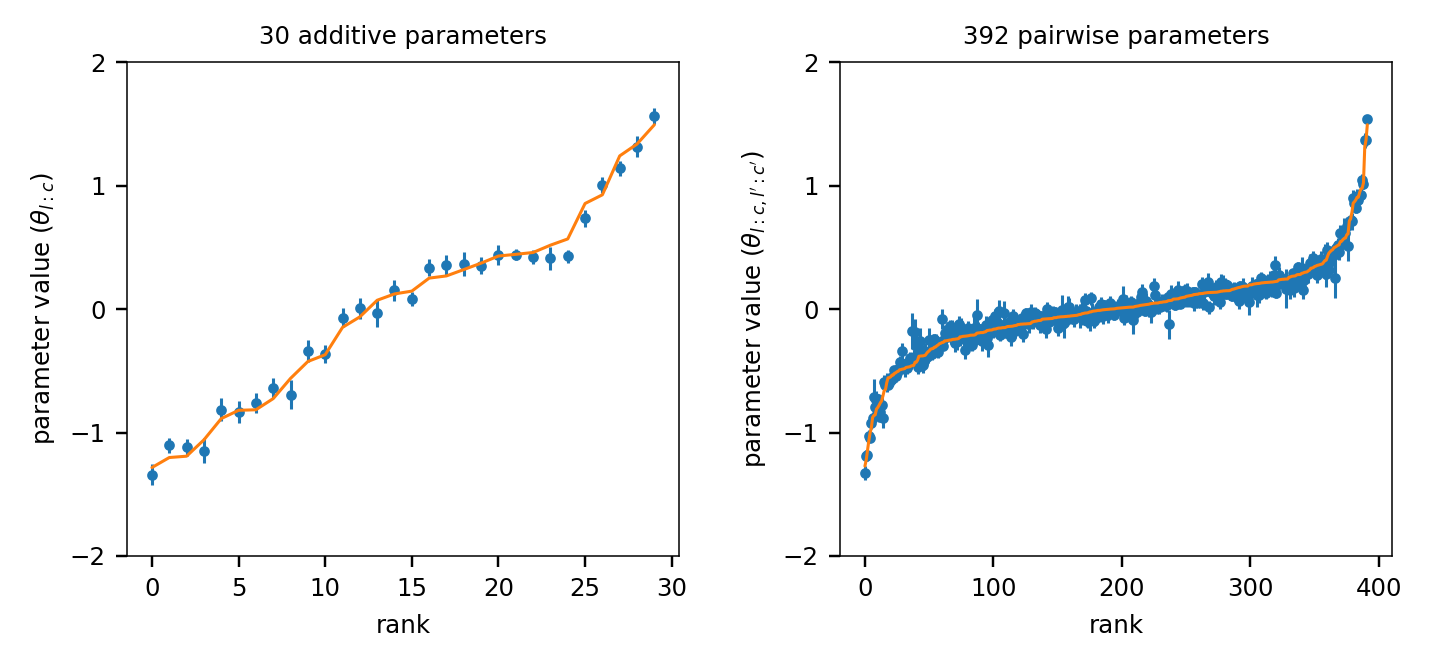

Figure saved figure to png/figS3_ipynb_2022.03.21.07h.08m.30s.png.


In [8]:
# Make figure
fig, axs = plt.subplots(1,2,figsize=[6.5,3], sharey=False)

# draw panel function
def draw(ax, 
         df, 
         ylabel, 
         title, 
         ylim=[-2,2], 
         yticks=[-2, -1, 0, 1, 2]):
    ax.errorbar(x=df.index,
                y=df['mean'],
                yerr=df['std'],
                label='estimated',
                linewidth=0,
                elinewidth=1,
                marker='.',
                markersize=5)
    ax.plot(df.index,
            df['true'].values,
            label='true',
            linewidth=1,
            zorder=10)
    #ax.set_xticks([])
    #ax.legend()
    ax.set_title(title)
    ax.set_xlabel('rank')
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)

draw(ax=axs[0],
     df=theta_lc_df,
     ylabel=r'parameter value ($\theta_{l:c}$)',
     title=f'{len(theta_lc_df)} additive parameters')

draw(ax=axs[1],
     df=theta_lclc_df,
     ylabel=r"parameter value ($\theta_{l:c,l':c'}$)",
     title=f'{len(theta_lclc_df)} pairwise parameters')

# Tighten layout
fig.tight_layout(w_pad=2)
            
# Save figure
save_fig_with_date_stamp(fig, fig_name)